# Investigating Bitcoin Peer Data with bitnode.io and Ipython Notebooks

Author: John Naulty Jr.


In [2]:
import pprint
import json

import requests
import pandas as pd
import geopandas
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()


pp = pprint.PrettyPrinter(indent=4)

### Interfacing with the bitnode api

In [3]:
# https://bitnodes.io/api/


def make_request(url):
    r = requests.get(url)
    if r.status_code == 200:
        return r.json()
    return False

def write_json(file_name, json_data):
    """
    store responses in json files
    """
    with open(file_name, 'w', encoding='utf-8') as f:
        json.dump(json_data, f, ensure_ascii=False, indent=4)
        
def load_json(file_name):
    with open(file_name) as json_file:
        data = json.load(json_file)
        return data
    
    

def list_snapshot(save_response=False):
    """https://bitnodes.io/api/v1/snapshots/"""
    snapshot_url = "https://bitnodes.io/api/v1/snapshots/"
    snapshots = make_request(snapshot_url)
    pp.pprint(snapshots)
    if save_response:
        count = snapshots["count"]
        file_name = f"{count}.snapshots.json"
        print(f"writing file to: {file_name}")
        write_json(file_name, snapshots)
        

def get_nodes(snapshot_timestamp="latest", save_response=False):
    """
    https://bitnodes.io/api/v1/snapshots/<TIMESTAMP>/
    <TIMESTAMP> can be replaced with "latest" to get the list of all reachable nodes from the latest snapshot.

    """
    nodes_url = f"https://bitnodes.io/api/v1/snapshots/{snapshot_timestamp}"
    nodes = make_request(nodes_url)
    
    pp.pprint(nodes)
    if save_response:
        height = nodes["latest_height"]
        file_name = f"{height}.{snapshot_timestamp}.nodes.json"
        print(f"writing file to: {file_name}")
        write_json(file_name, nodes)
    return nodes

def tx_data_propagation(transaction):
    """
    https://bitnodes.io/api/#data-propagation
    https://bitnodes.io/api/v1/inv/<INV_HASH>/
    Values in stats represent the following information:

    head - Arrival times for the first 10 nodes in a list of ["<ADDRESS>:<PORT>", <TIMESTAMP>].
    min - Delta for earliest arrival time. Value can be 0 if the delta is less than 1 millisecond.
    max - Delta for latest arrival time.
    mean - Average of deltas.
    std - Standard deviation of deltas.
    50% - 50th percentile of deltas.
    90% - 90th percentile of deltas.
    """
    pass


### Saving Snapshot Data to Disk

In [4]:
# list_snapshot(save_response=True)
# nodes = get_nodes(save_response=True)

### Loading Snapshot Data from Disk

In [5]:
nodes = load_json("628680.latest.nodes.json")

## Data Processing with Pandas

In [13]:


headers = [
    "Protocol version",
    "User agent",
    "Connected since",
    "Services",
    "Height",
    "Hostname",
    "City",
    "Country code",
    "Latitude",
    "Longitude",
    "Timezone",
    "ASN",
    "Organization name"
]

node_df = pd.DataFrame.from_dict(nodes['nodes'], orient='index',columns=headers)
node_df = node_df.fillna('')


node_df[["User agent", "Country code", "Organization name" ]].describe()
org_name = node_df["Organization name"]

print(node_df[["Country code", "Organization name"]].describe())
print()
print(org_name.value_counts(normalize=True).nlargest(10))


       Country code Organization name
count          9234              9234
unique           96              1034
top              US       Tor network
freq           1854              1544

Tor network                          0.167208
Hetzner Online GmbH                  0.110461
Amazon.com, Inc.                     0.076998
DigitalOcean, LLC                    0.052415
OVH SAS                              0.051115
Comcast Cable Communications, LLC    0.021009
Contabo GmbH                         0.019710
Google LLC                           0.018302
Alibaba (US) Technology Co., Ltd.    0.014620
Charter Communications Inc           0.013537
Name: Organization name, dtype: float64


[Text(0, 0.5, ''), (0.0, 0.25), Text(0.5, 0, 'Percentage Peers in Countries')]

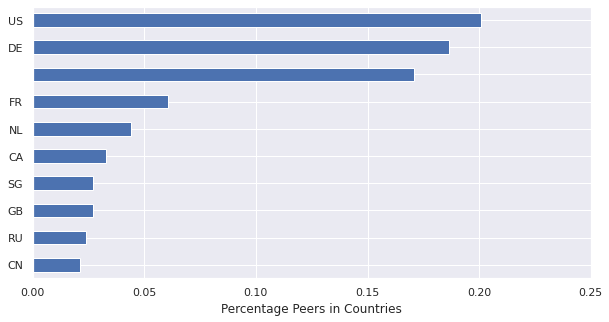

In [242]:
f, ax = plt.subplots(figsize=(10, 5))
node_df["Country code"].value_counts(normalize=True).nlargest(10).sort_values().plot.barh()
ax.set(xlim=(0, .25),ylabel="",
       xlabel="Percentage Peers in Countries")

[Text(0, 0.5, ''),
 (0.0, 0.2),
 Text(0.5, 0, 'Percentage of ISP/Network for Bitcoin Peers in World')]

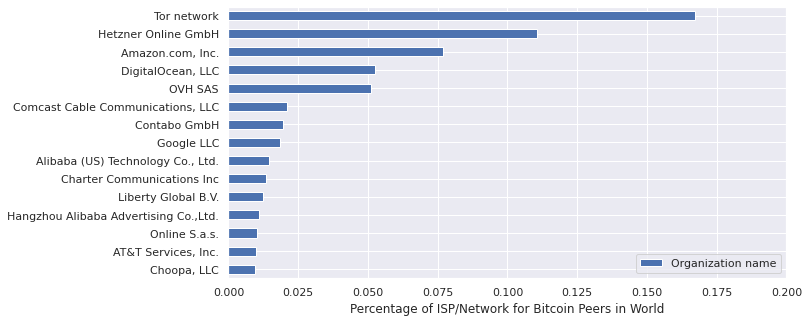

In [198]:
f, ax = plt.subplots(figsize=(10, 5))

org_name.value_counts(normalize=True).nlargest(15).sort_values().plot.barh()
ax.legend(ncol=2, loc="lower right", frameon=True)
ax.set(xlim=(0, .20),ylabel="",
       xlabel="Percentage of ISP/Network for Bitcoin Peers in World")

In [15]:
gdf = geopandas.GeoDataFrame(
    node_df, crs="epsg:4269", geometry=geopandas.points_from_xy(node_df.Longitude, node_df.Latitude))
gdf = gdf.fillna('')
#gdf.geometry.head()

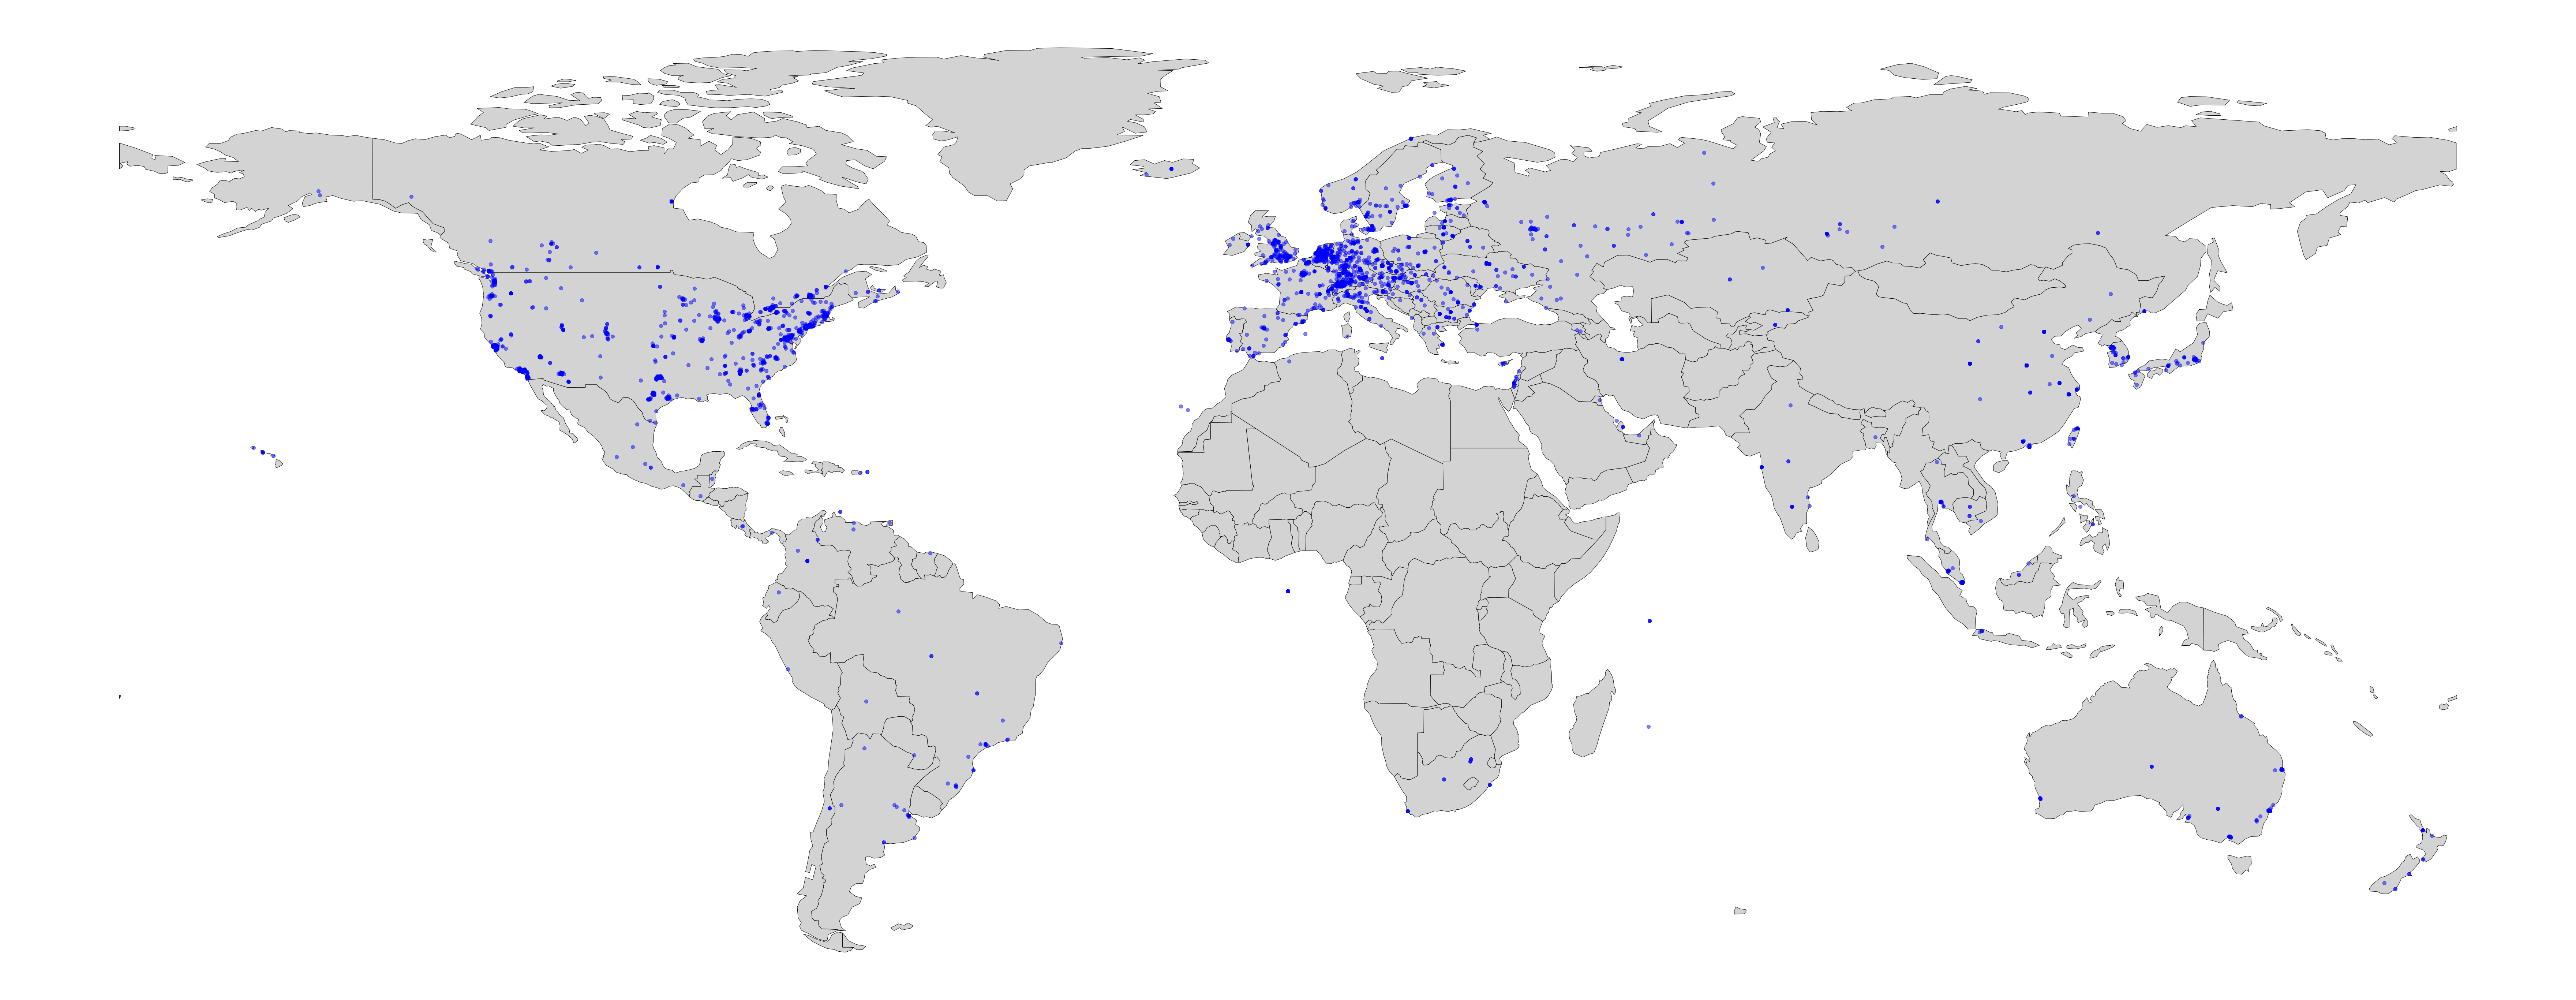

In [16]:
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
world = world[~world.continent.isin(['Antarctica'])]

# We restrict to South America.
ax = world.plot(color='lightgrey', linewidth=1, edgecolor='black', figsize=(150,50))

# We can now plot our ``GeoDataFrame``.
gdf.plot(markersize=100, color='blue', alpha=0.5, ax=ax)
ax.axis('off')
plt.show()


In [17]:
states = geopandas.read_file("shape-data/cb_2018_us_state_500k/cb_2018_us_state_500k.shp")
# Get rid of Guam, Mariana Islands and Virgin Islands
states = states[states.STATEFP.astype(int) < 60]
# Get rid of Hawaii and Alaska
states = states[~states.NAME.isin(['Hawaii', 'Alaska'])]
#states.tail(5)

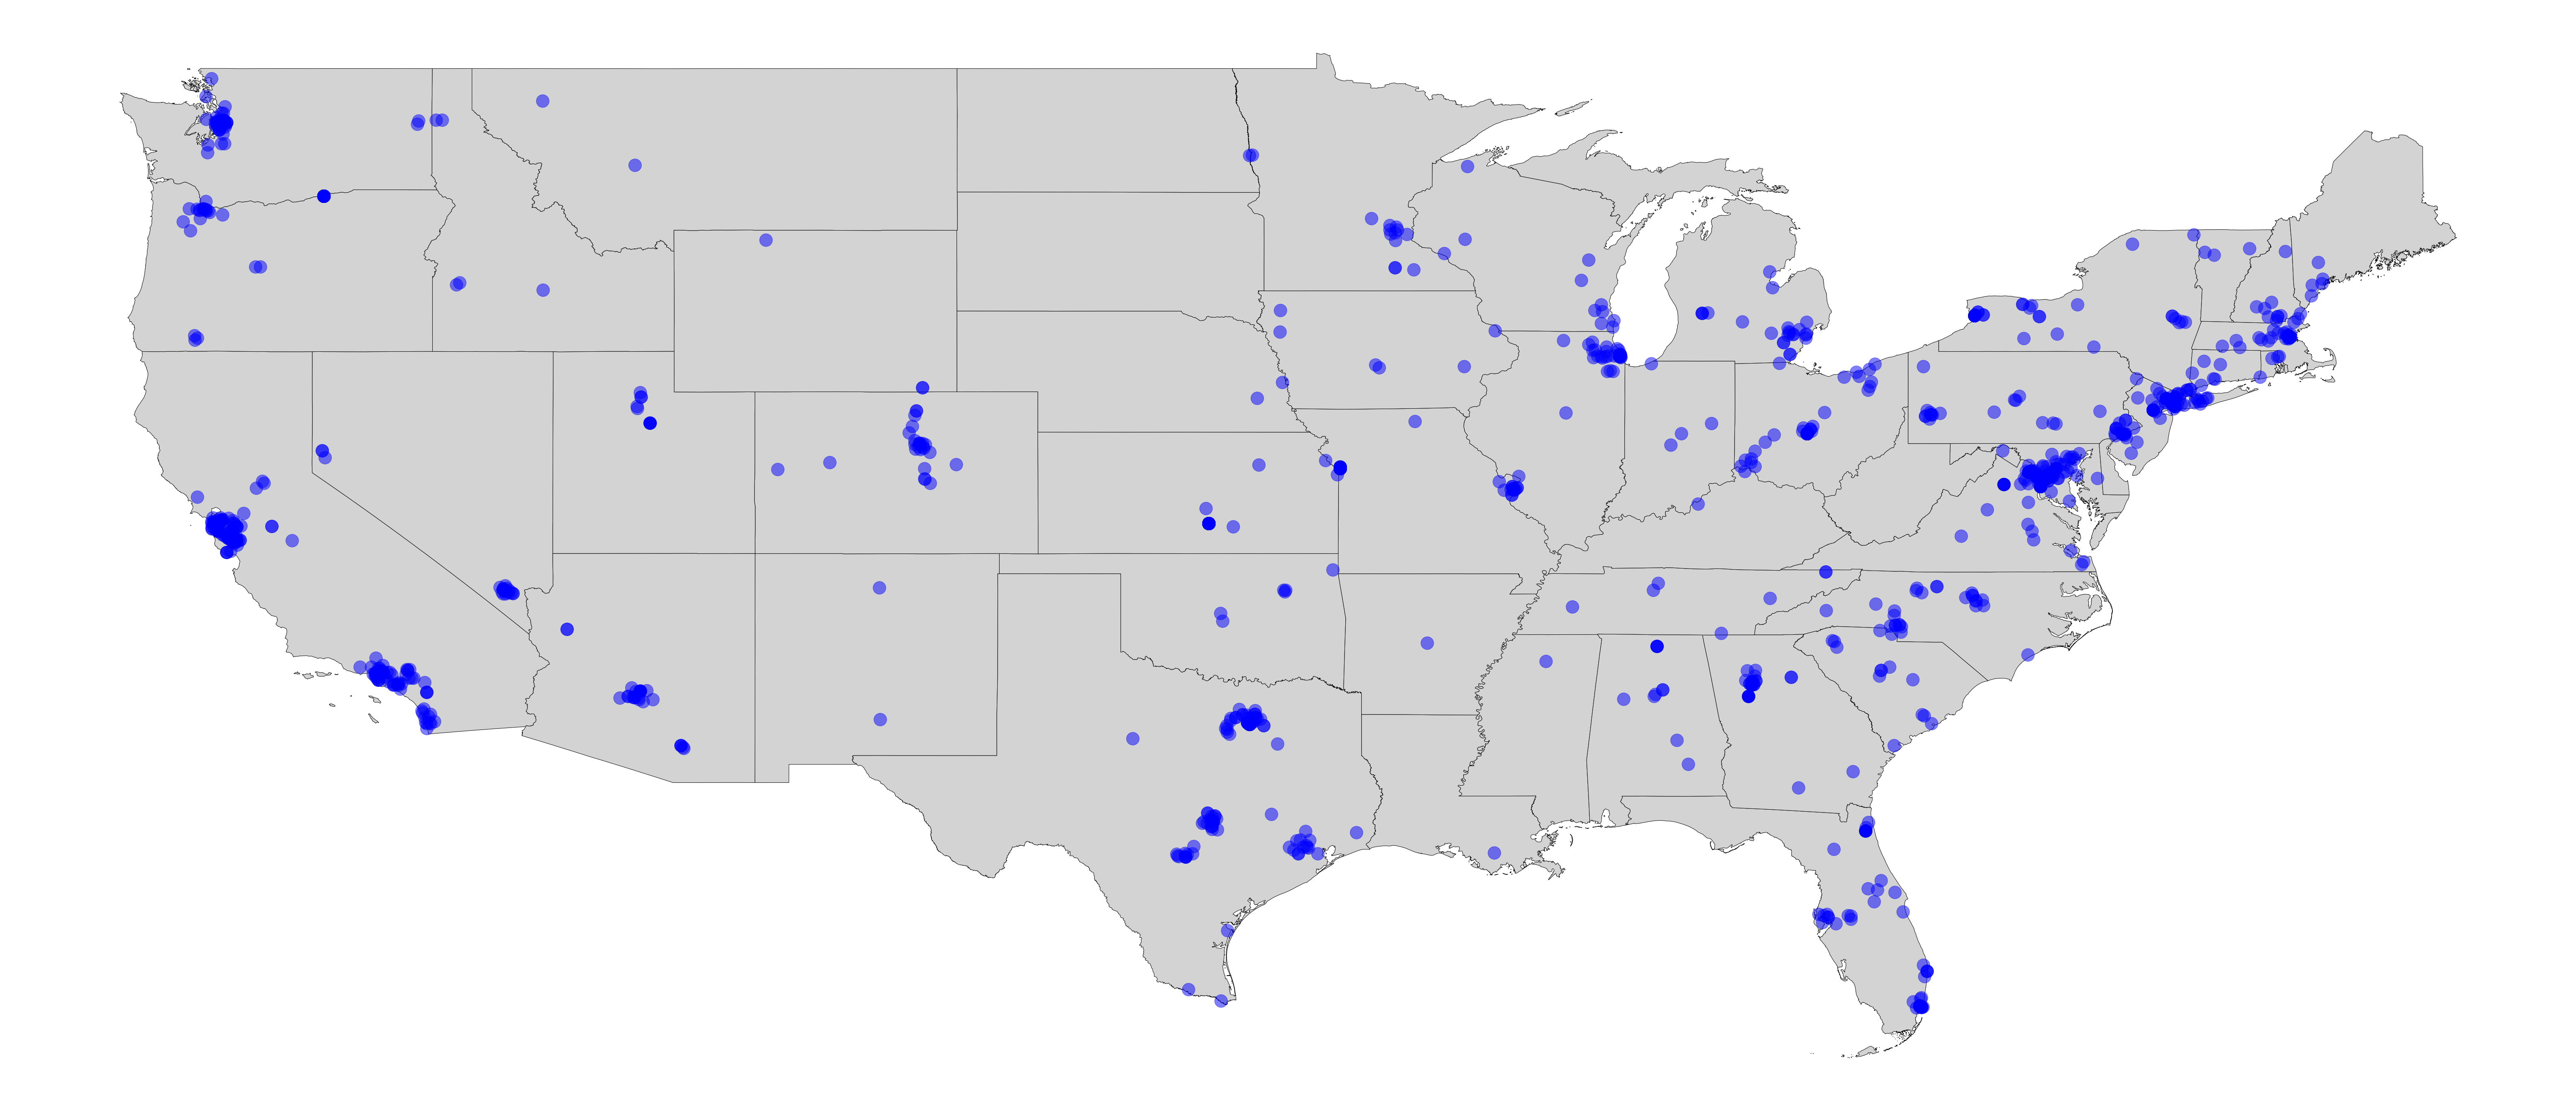

In [190]:
ax = states.plot(color='lightgrey', linewidth=1, edgecolor='black', figsize=(150,50))

# We can now plot our ``GeoDataFrame``.
#gdf.plot(markersize=10, color='pink', alpha=0.5, ax=ax)

us_intersection = geopandas.overlay(gdf, states, how='intersection')
us_intersection.plot(markersize=1000, color='blue', alpha=0.5, ax=ax)
ax.axis('off')
ax.set(xlabel="All Peers in US")
plt.show()

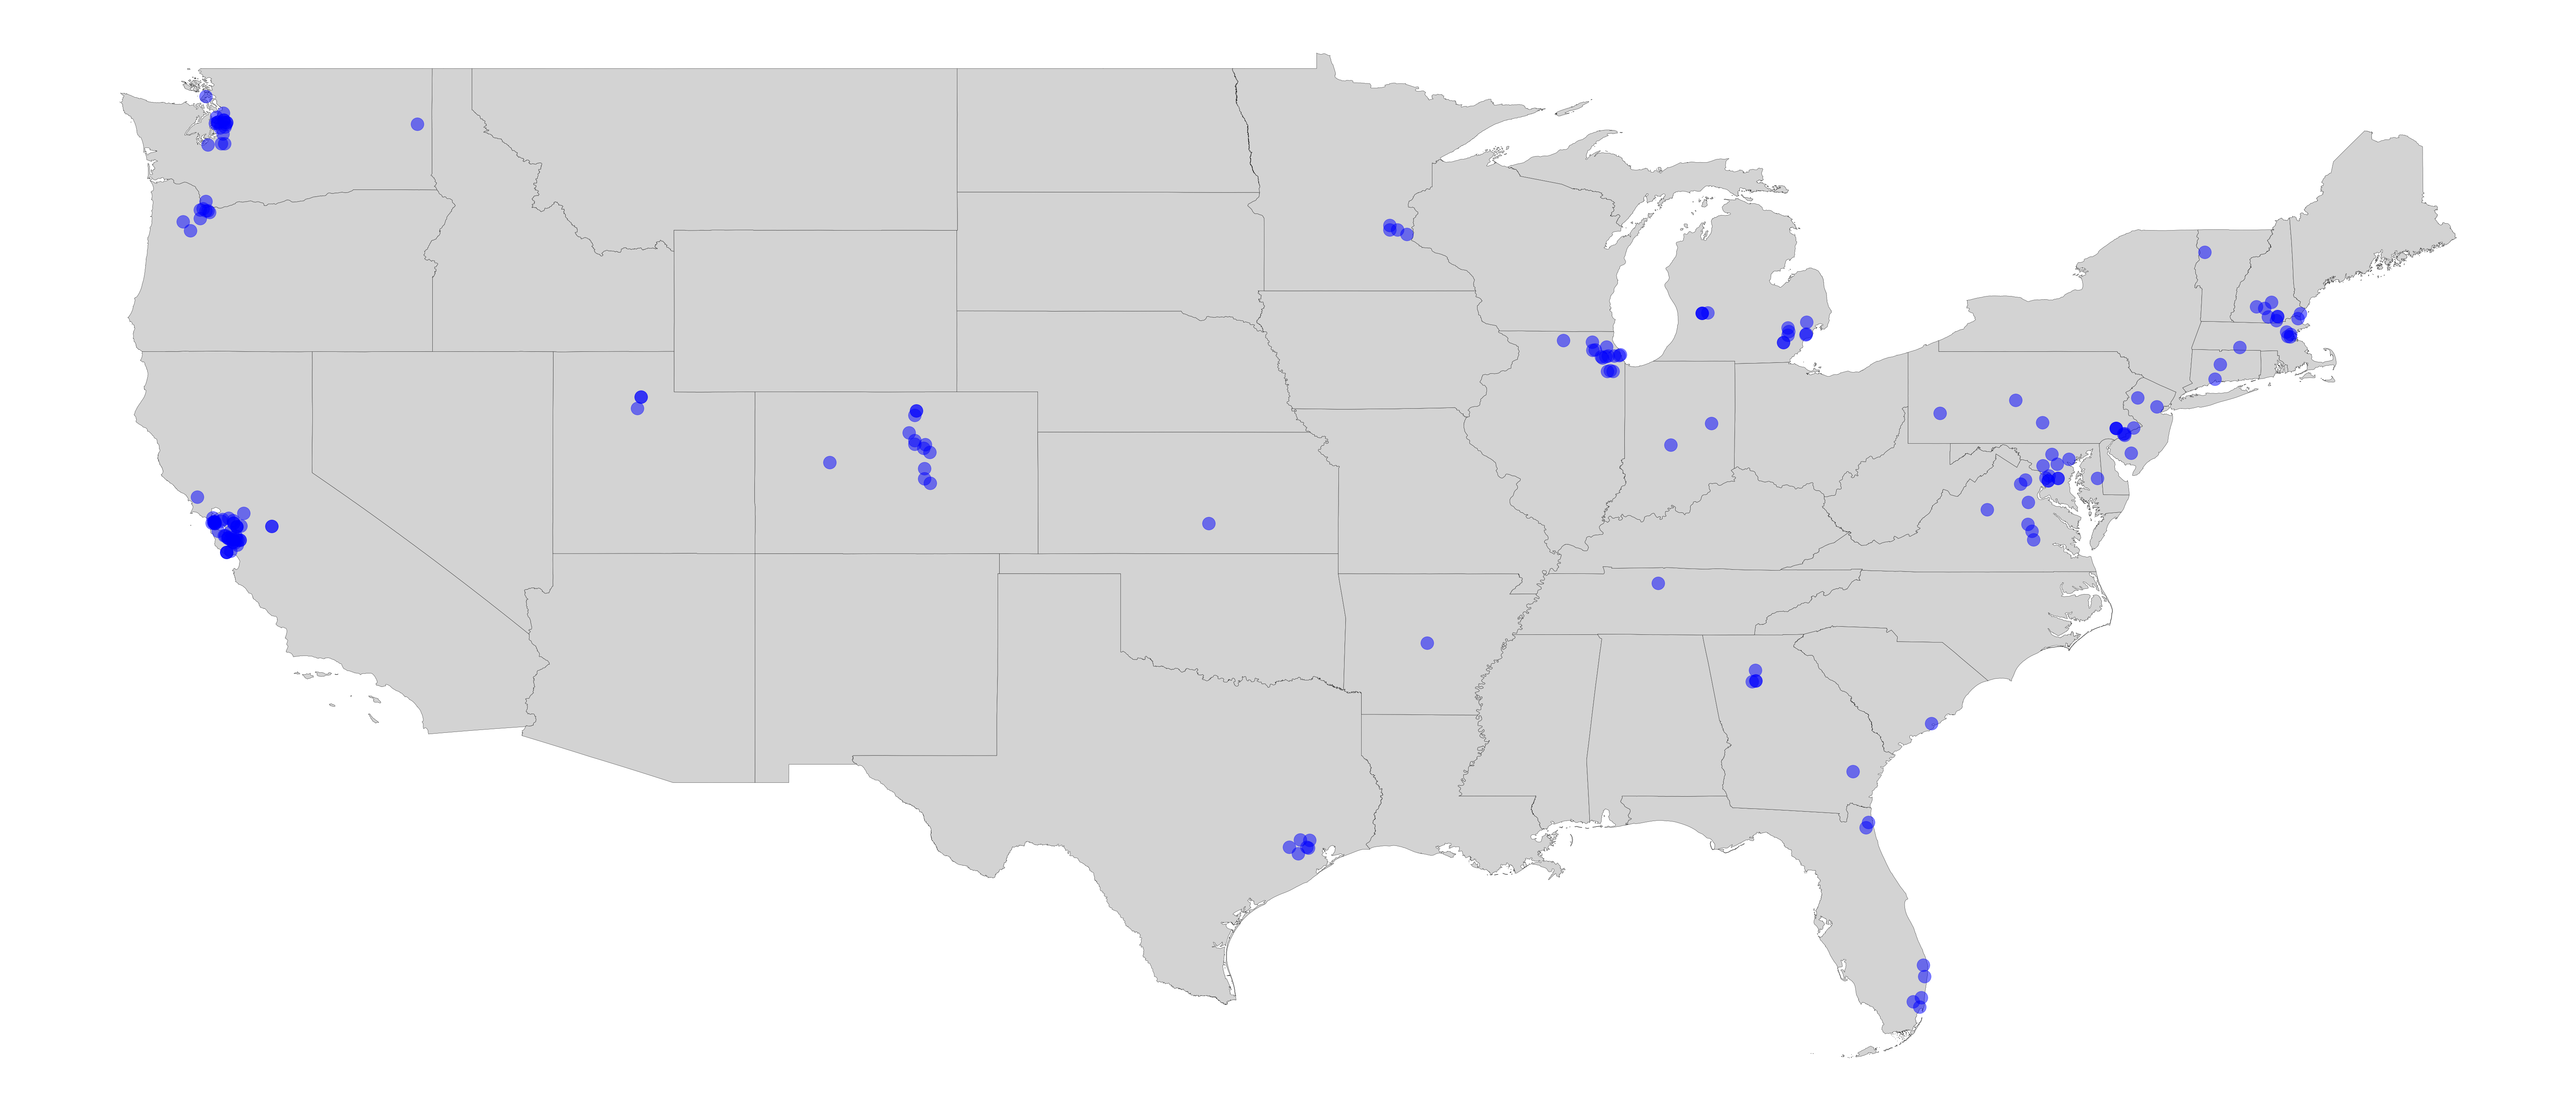

In [202]:
gdf = gdf.fillna('')
comcast_nodes = gdf[gdf["Organization name"].str.contains('Comcast')]
comcast_intersection = geopandas.overlay(comcast_nodes, states, how='intersection')
ax = states.plot(color='lightgrey', linewidth=0.5, edgecolor='black', figsize=(150,50))
comcast_intersection.plot(markersize=1000, color='blue', alpha=0.5, ax=ax)
ax.axis('off')
#ax.set(xlabel="Comcast Peers in US")
plt.show()


[Text(0, 0.5, ''),
 (0.0, 0.2),
 Text(0.5, 0, 'Percentage of ISP/Network for Bitcoin Peers in US')]

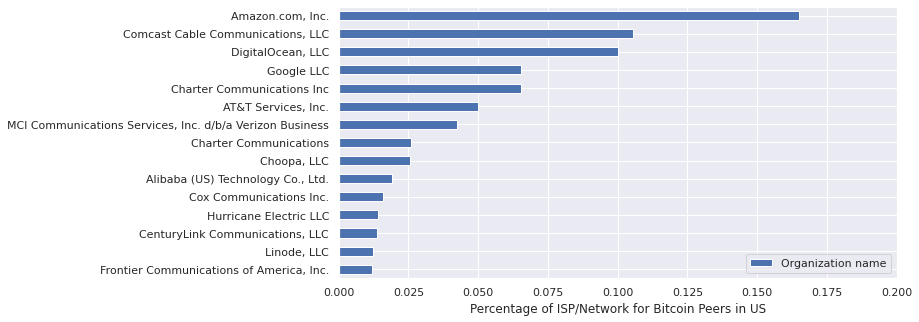

In [201]:
f, ax = plt.subplots(figsize=(10, 5))
us_intersection["Organization name"].value_counts(normalize=True).nlargest(15).sort_values().plot.barh()
ax.legend(ncol=2, loc="lower right", frameon=True)
ax.set(xlim=(0, .20),ylabel="",
       xlabel="Percentage of ISP/Network for Bitcoin Peers in US")

In [210]:
us_intersection["NAME"].value_counts(normalize=False).nlargest(10)

California    367
Virginia      194
New Jersey    162
Kansas        148
Ohio          121
Oregon        106
Texas         100
New York       82
Washington     48
Florida        45
Name: NAME, dtype: int64

In [22]:
us_intersection[["NAME", "Organization name"]].groupby('NAME').describe()

Organization name         \
                                 count unique   
NAME                                            
Alabama                             11      5   
Arizona                             27     12   
Arkansas                             1      1   
California                         367     43   
Colorado                            25      7   
Connecticut                         10      5   
District of Columbia                 5      4   
Florida                             45     14   
Georgia                             32      8   
Idaho                                5      3   
Illinois                            30     11   
Indiana                              4      3   
Iowa                                 6      5   
Kansas                             148     50   
Kentucky                             2      2   
Louisiana                            1      1   
Maine                                5      2   
Maryland                            31      5   
Massachusetts                       37      8   
Michigan                            23      6   
Minnesota                           13      7   
Mississippi                          1      1   
Missouri                            35     10   
Montana                              2      2   
Nebraska                             2      2   
Nevada                              21     10   
New Hampshire                       10      3   
New Jersey                         162      8   
New Mexico                           2      2   
New York                            82     19   
North Carolina                      26      5   
North Dakota                         1      1   
Ohio                               121      8   
Oklahoma                             6      3   
Oregon                             106     10   
Pennsylvania                        38     12   
Rhode Island                         4      2   
South Carolina                      14      9   
Tennessee                            7      5   
Texas                              100     22   
Utah                                10      4   
Vermont                              3      3   
Virginia                           194     12   
Washington                          48     13   
West Virginia                        1      1   
Wisconsin                           11      5   
Wyoming                              3      2   

                                                                              
                                                                    top freq  
NAME                                                                          
Alabama                                        WideOpenWest Finance LLC    4  
Arizona                                         Cox Communications Inc.    9  
Arkansas                              Comcast Cable Communications, LLC    1  
California                                                   Google LLC   71  
Colorado                              Comcast Cable Communications, LLC   13  
Connecticut                                   Cablevision Systems Corp.    3  
District of Columbia  MCI Communications Services, Inc. d/b/a Verizo...    2  
Florida                                     Charter Communications, Inc   11  
Georgia                                             AT&T Services, Inc.   13  
Idaho                                                         Cable One    2  
Illinois                              Comcast Cable Communications, LLC   15  
Indiana                               Comcast Cable Communications, LLC    2  
Iowa                                       Mediacom Communications Corp    2  
Kansas                                           Hurricane Electric LLC   22  
Kentucky                                     Charter Communications Inc    1  
Louisiana                                           AT&T Services, Inc.    1  
Maine                                        Charter Communications I

[Text(0, 0.5, ''),
 (0.0, 50.0),
 Text(0.5, 0, 'Number of Comcast Peers by State')]

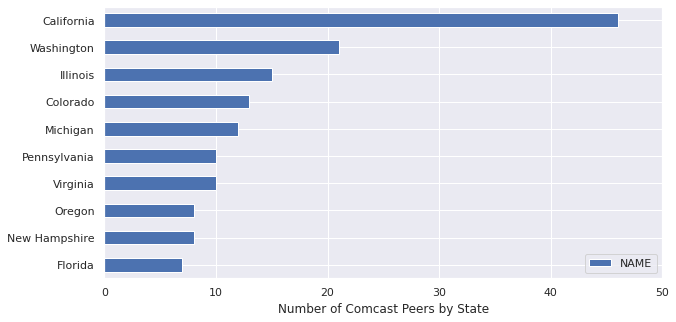

In [186]:
f, ax = plt.subplots(figsize=(10, 5))
sns.set_color_codes("pastel")
comcast_intersection["NAME"].value_counts(normalize=False).nlargest(10).sort_values().plot.barh()

ax.legend(ncol=2, loc="lower right", frameon=True)
ax.set(xlim=(0, 50),ylabel="",
       xlabel="Number of Comcast Peers by State")

In [24]:
comcast_intersection.head()

Protocol version             User agent  Connected since  Services  Height  \
0             70015     /Satoshi:0.19.0.1/       1588428662      1033  628573   
1             70015       /Satoshi:0.19.1/       1588410915      1037  628680   
2             70015  /Satoshi:0.19.1(BTC)/       1588472522      1033  628680   
3             70015     /Satoshi:0.19.0.1/       1588477720      1032  628679   
4             70015       /Satoshi:0.18.1/       1588410914      1037  628680   

                             Hostname             City Country code  Latitude  \
0   c-73-64-231-2.hsd1.pa.comcast.net    State College           US   40.7957   
1   c-73-81-10-40.hsd1.pa.comcast.net  King of Prussia           US   40.1005   
2  c-71-60-192-20.hsd1.pa.comcast.net       Pittsburgh           US   40.4760   
3   c-73-81-10-40.hsd1.pa.comcast.net  King of Prussia           US   40.1005   
4    c-73-81-24-6.hsd1.pa.comcast.net     Philadelphia           US   39.9597   

   Longitude  ... STATEFP   STATENS     AFFGEOID GEOID STUSPS          NAME  \
0   -77.8618  ...      42  01779798  0400000US42    42     PA  Pennsylvania   
1   -75.3709  ...      42  01779798  0400000US42    42     PA  Pennsylvania   
2   -79.7355  ...      42  01779798  0400000US42    42     PA  Pennsylvania   
3   -75.3709  ...      42  01779798  0400000US42    42     PA  Pennsylvania   
4   -75.1995  ...      42  01779798  0400000US42    42     PA  Pennsylvania   

  LSAD         ALAND      AWATER                    geometry  
0   00  115884442321  3394589990  POINT (-77.86180 40.79570)  
1   00  115884442321  3394589990  POINT (-75.37090 40.10050)  
2   00  115884442321  3394589990  POINT (-79.73550 40.47600)  
3   00  115884442321  3394589990  POINT (-75.37090 40.10050)  
4   00  115884442321  3394589990  POINT (-75.19950 39.95970)  

[5 rows x 23 columns]

In [117]:
comcast_intersection["NAME"].value_counts(normalize=True)


California              0.237113
Washington              0.108247
Illinois                0.077320
Colorado                0.067010
Michigan                0.061856
Virginia                0.051546
Pennsylvania            0.051546
New Hampshire           0.041237
Oregon                  0.041237
Florida                 0.036082
Maryland                0.036082
Texas                   0.030928
Massachusetts           0.030928
Georgia                 0.025773
Minnesota               0.020619
New Jersey              0.015464
Utah                    0.015464
Indiana                 0.010309
Connecticut             0.010309
South Carolina          0.005155
Arkansas                0.005155
Vermont                 0.005155
Kansas                  0.005155
District of Columbia    0.005155
Tennessee               0.005155
Name: NAME, dtype: float64

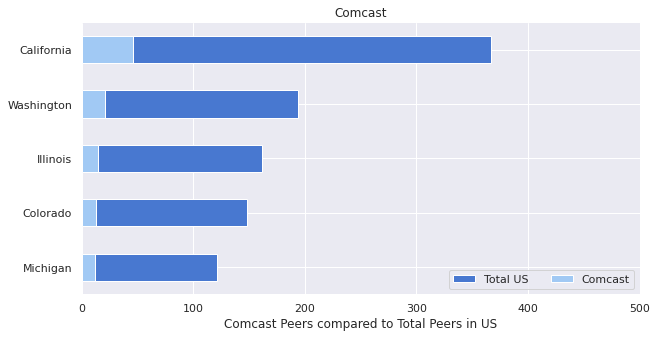

In [153]:
import seaborn as sns
sns.set()
comcast_count = comcast_intersection["NAME"].value_counts(normalize=False).nlargest().sort_values()
total_count = us_intersection["NAME"].value_counts(normalize=False).nlargest().sort_values()

f, ax = plt.subplots(figsize=(10, 5))


#sns.barplot(comcast_count)
sns.set_color_codes("muted")
total_count.plot.barh(color="b", label="Total US", subplots=True)
sns.set_color_codes("pastel")
comcast_count.plot.barh(color="b", label="Comcast", subplots=True)


# Add a legend and informative axis label
ax.legend(ncol=2, loc="lower right", frameon=True)
ax.set(xlim=(0, 500),ylabel="",
       xlabel="Comcast Peers compared to Total Peers in US")
sns.despine(left=True, bottom=True)

In [83]:
california_count = us_intersection[us_intersection["NAME"] == "California"]
us_intersection["NAME"].unique()
#f, ax = plt.subplots(figsize=(10, 5))

sns.set_color_codes("pastel")
#sns.barplot(comcast_count)
#comcast_count.plot.barh(color="b", label="Comcast")
sns.set_color_codes("muted")
#total_count.plot.barh(color="b", label="Total US")

# Add a legend and informative axis label
#ax.legend(ncol=2, loc="lower right", frameon=True)
#ax.set(xlim=(0, .5),ylabel="",
       #xlabel="Comcast Peers compared to Total Peers in US")
#sns.despine(left=True, bottom=True)

[Text(0, 0.5, ''),
 (0.0, 0.25),
 Text(0.5, 0, 'Percentage of ISP/Network for Bitcoin Peers in California')]

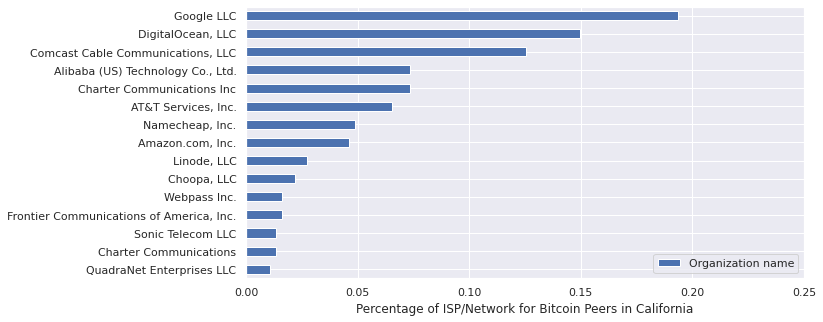

In [156]:
california_gdf = us_intersection[us_intersection["NAME"] == 'California']
f, ax = plt.subplots(figsize=(10, 5))
sns.set_color_codes("pastel")
california_gdf['Organization name'].value_counts(normalize=True).nlargest(15).sort_values().plot.barh()
ax.legend(ncol=2, loc="lower right", frameon=True)
ax.set(xlim=(0, .25),ylabel="",
       xlabel="Percentage of ISP/Network for Bitcoin Peers in California")

[Text(0, 0.5, 'State'),
 (0.0, 0.2),
 Text(0.5, 0, 'Percentage of ISP/Network for Bitcoin Peers in the US')]

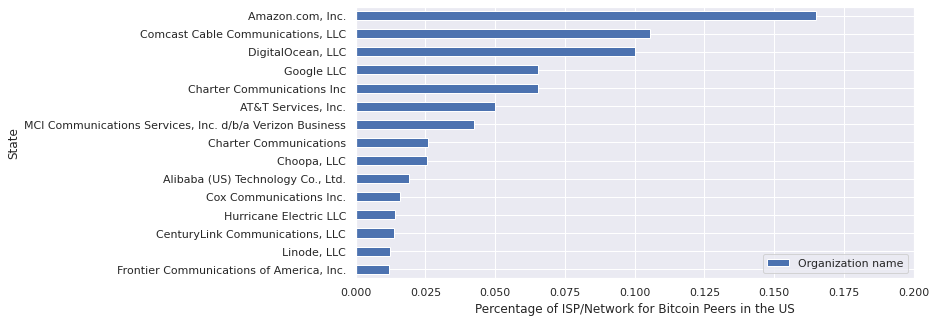

In [155]:

f, ax = plt.subplots(figsize=(10, 5))
sns.set_color_codes("pastel")
us_intersection['Organization name'].value_counts(normalize=True).nlargest(15).sort_values().plot.barh()

ax.legend(ncol=2, loc="lower right", frameon=True)
ax.set(xlim=(0, .2),ylabel="State",
       xlabel="Percentage of ISP/Network for Bitcoin Peers in the US")

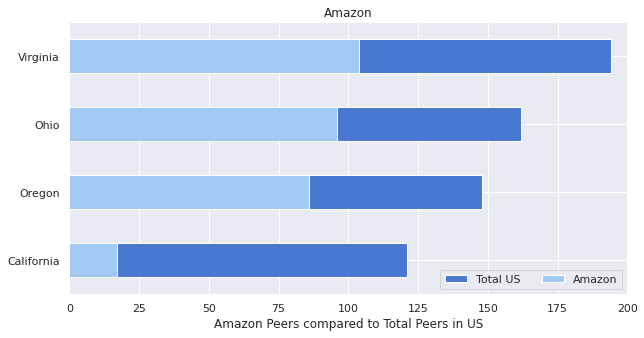

In [151]:
amazon_gdf = us_intersection[us_intersection["Organization name"] == 'Amazon.com, Inc.']
amazon_count = amazon_gdf["NAME"].value_counts(normalize=False).nlargest().sort_values()
total_count = us_intersection["NAME"].value_counts(normalize=False).nlargest().sort_values()

f, ax = plt.subplots(figsize=(10, 5))


#sns.barplot(comcast_count)

sns.set_color_codes("muted")
total_count.plot.barh(color="b", label="Total US", subplots=True)
sns.set_color_codes("pastel")
amazon_count.plot.barh(color="b", label="Amazon", subplots=True)



# Add a legend and informative axis label
ax.legend(ncol=2, loc="lower right", frameon=True)
ax.set(xlim=(0, 200),ylabel="",
       xlabel="Amazon Peers compared to Total Peers in US")
sns.despine(left=True, bottom=True)

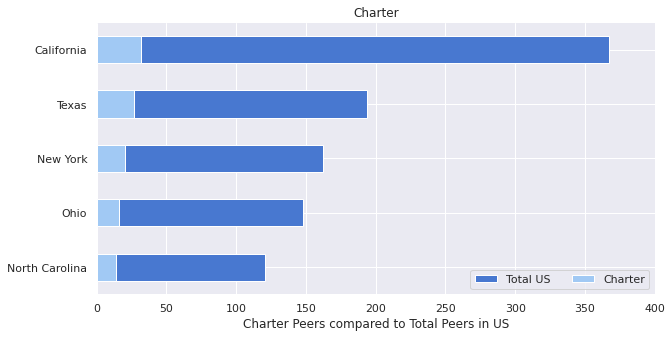

In [166]:
charter_gdf = us_intersection[us_intersection["Organization name"].str.contains('Charter')]
charter_count = charter_gdf["NAME"].value_counts(normalize=False).nlargest().sort_values()
total_count = us_intersection["NAME"].value_counts(normalize=False).nlargest().sort_values()

f, ax = plt.subplots(figsize=(10, 5))


#sns.barplot(comcast_count)

sns.set_color_codes("muted")
total_count.plot.barh(color="b", label="Total US", subplots=True)
sns.set_color_codes("pastel")
charter_count.plot.barh(color="b", label="Charter", subplots=True)



# Add a legend and informative axis label
ax.legend(ncol=2, loc="lower right", frameon=True)
ax.set(xlim=(0, 400),ylabel="",
       xlabel="Charter Peers compared to Total Peers in US")
sns.despine(left=True, bottom=True)

[Text(0, 0.5, ''),
 (0.0, 25.0),
 Text(0.5, 0, 'ISP/Network for Bitcoin Peers in Kansas')]

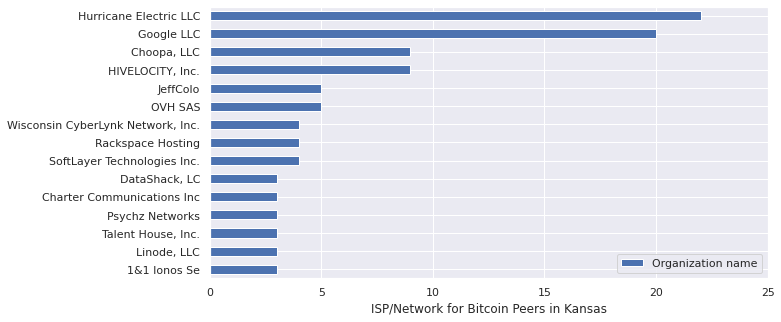

In [232]:
california_gdf = us_intersection[us_intersection["NAME"] == 'Kansas']
f, ax = plt.subplots(figsize=(10, 5))
sns.set_color_codes("pastel")
california_gdf['Organization name'].value_counts(normalize=False).nlargest(15).sort_values().plot.barh()
ax.legend(ncol=2, loc="lower right", frameon=True)
ax.set(xlim=(0, 25),ylabel="",
       xlabel="ISP/Network for Bitcoin Peers in Kansas")

[Text(0, 0.5, ''),
 (0.0, 0.3),
 Text(0.5, 0, 'Percentage of ISP/Network for Bitcoin Peers in Texas')]

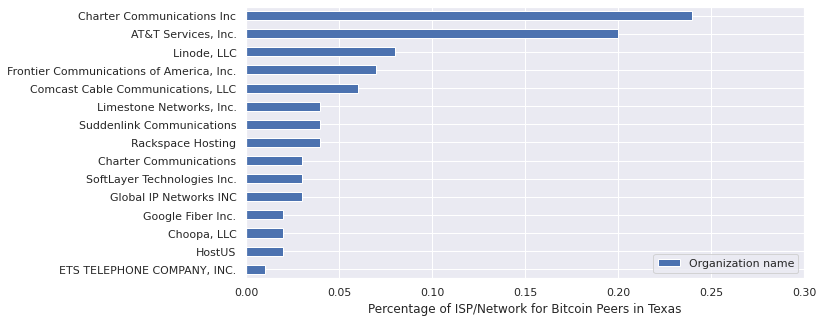

In [231]:
california_gdf = us_intersection[us_intersection["NAME"] == 'Texas']
f, ax = plt.subplots(figsize=(10, 5))
sns.set_color_codes("pastel")
california_gdf['Organization name'].value_counts(normalize=True).nlargest(15).sort_values().plot.barh()
ax.legend(ncol=2, loc="lower right", frameon=True)
ax.set(xlim=(0, .3),ylabel="",
       xlabel="Percentage of ISP/Network for Bitcoin Peers in Texas")